In [1]:
# CELL 1: Setup & Load (Unchanged)
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, max, count, desc, countDistinct, stddev, when, greatest, lit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from pyspark.sql.types import StringType

spark = SparkSession.builder \
    .appName("Misinfo EDA - Fixed for Overlaps") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

base_path = "hdfs://namenode:9000/user/misinfo"
nodes_df = spark.read.parquet(f"{base_path}/all_nodes_clean.parquet")
edges_df = spark.read.parquet(f"{base_path}/all_edges_clean.parquet")

nodes_df.cache()
edges_df.cache()

print(f"Loaded {nodes_df.count():,} nodes and {edges_df.count():,} edges.")
nodes_df.printSchema()

Loaded 214,851 nodes and 504,058 edges.
root
 |-- id: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- friends: integer (nullable = true)
 |-- followers: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- graph_id: string (nullable = true)



--- GLOBAL STATS WITH DEDUPLICATION ---
+--------------+--------------+---------------+-----------------+----------+
|dominant_label|Total_5G_Nodes|Total_Non_Nodes|Total_Other_Nodes|Num_Graphs|
+--------------+--------------+---------------+-----------------+----------+
|Non_Conspiracy|1589          |133253         |5772             |2067      |
|Other         |14977         |23188          |32201            |400       |
|5G_Conspiracy |2481          |699            |691              |35        |
+--------------+--------------+---------------+-----------------+----------+



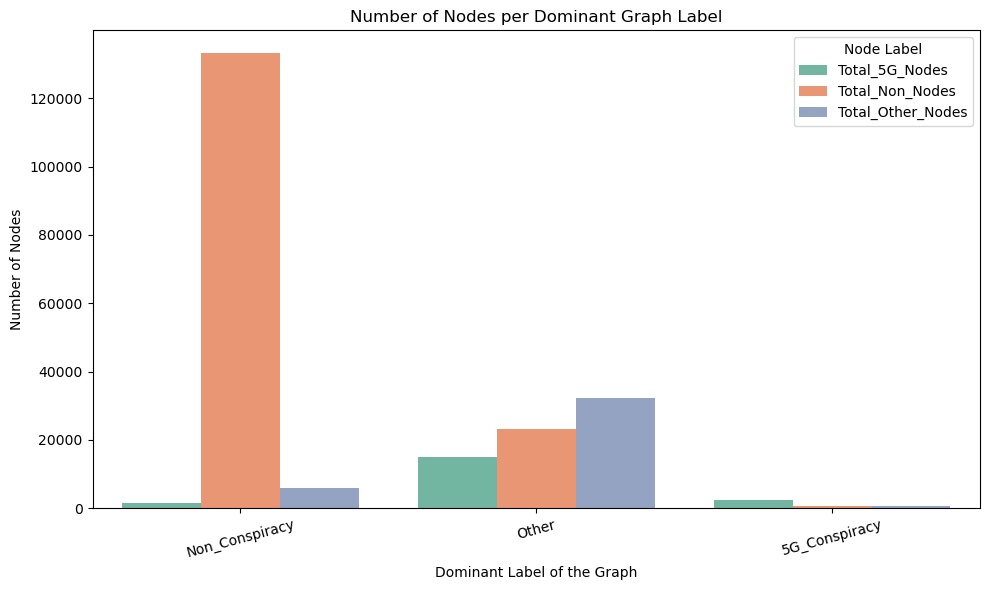

In [2]:
# CELL 2 – GLOBAL STATS WITH DEDUPLICATION (FINAL BULLETPROOF VERSION)

from pyspark.sql.functions import col, when, greatest, sum as _sum, count

print("--- GLOBAL STATS WITH DEDUPLICATION ---")

# 1. Pivot + force everything to integer 0 instead of null
pivot_nodes = (nodes_df
               .groupBy("graph_id")
               .pivot("label")
               .count()
               .na.fill(0))                               # <-- turns null → 0

# 2. Make sure the three columns are really integers (sometimes Spark infers String!)
pivot_nodes = pivot_nodes \
    .withColumn("5G_Conspiracy_Graphs", col("5G_Conspiracy_Graphs").cast("int")) \
    .withColumn("Non_Conspiracy_Graphs", col("Non_Conspiracy_Graphs").cast("int")) \
    .withColumn("Other_Graphs", col("Other_Graphs").cast("int"))

# 3. Create dominant label safely
pivot_nodes = pivot_nodes = pivot_nodes.withColumn(
    "dominant_label",
    when(col("5G_Conspiracy_Graphs") >= col("Non_Conspiracy_Graphs") + col("Other_Graphs"), "5G_Conspiracy")
    .when(col("Non_Conspiracy_Graphs") >= col("5G_Conspiracy_Graphs") + col("Other_Graphs"), "Non_Conspiracy")
    .otherwise("Other")
)

# 4. Aggregate
stats = pivot_nodes.groupBy("dominant_label").agg(
    _sum("5G_Conspiracy_Graphs").alias("Total_5G_Nodes"),
    _sum("Non_Conspiracy_Graphs").alias("Total_Non_Nodes"),
    _sum("Other_Graphs").alias("Total_Other_Nodes"),
    count("*").alias("Num_Graphs")
).orderBy(desc("Num_Graphs"))

stats.show(truncate=False)

# 5. Nice plot
pdf = stats.toPandas()
pdf_melt = pdf.melt(id_vars='dominant_label',
                     value_vars=['Total_5G_Nodes', 'Total_Non_Nodes', 'Total_Other_Nodes'],
                     var_name='Node_Type', value_name='Count')

plt.figure(figsize=(10,6))
sns.barplot(data=pdf_melt, x='dominant_label', y='Count', hue='Node_Type', palette='Set2')
plt.title("Number of Nodes per Dominant Graph Label")
plt.ylabel("Number of Nodes")
plt.xlabel("Dominant Label of the Graph")
plt.legend(title="Node Label")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

--- NODE-LEVEL DEGREE ANALYSIS (Within Mixed Graphs) ---
+---------------------+------------------+-------------+-----------------+
|label                |Avg_In_Degree     |Max_In_Degree|StdDev_In_Degree |
+---------------------+------------------+-------------+-----------------+
|Non_Conspiracy_Graphs|5.569384835479256 |344          |20.31307202713981|
|5G_Conspiracy_Graphs |17.803708182184604|1129         |58.16872498937038|
|Other_Graphs         |21.208393632416787|903          |60.06479582551472|
+---------------------+------------------+-------------+-----------------+



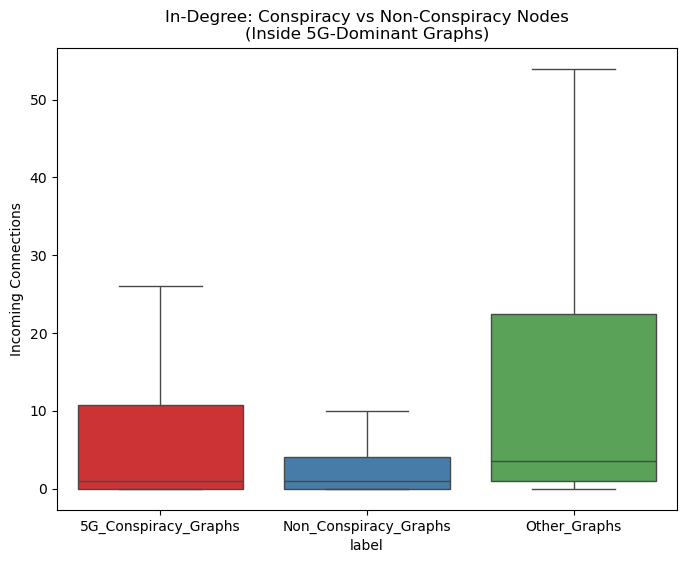

In [3]:
# CELL 3: In-Degree Distribution (Node-Level, Within Dominant Graphs)
print("--- NODE-LEVEL DEGREE ANALYSIS (Within Mixed Graphs) ---")

# Calculate in-degree
in_degree = edges_df.groupBy("dst_node_id").count().withColumnRenamed("count", "in_degree").withColumnRenamed("dst_node_id", "id")

degree_df = nodes_df.join(in_degree, "id", "left").na.fill({"in_degree": 0})

# Join with dominant labels
degree_df = degree_df.join(pivot_nodes.select("graph_id", "dominant_label"), "graph_id", "left")

# Filter to dominant 5G graphs for comparison
sg_degrees = degree_df.filter(col("dominant_label") == "5G_Conspiracy")

sg_degrees.groupBy("label").agg(
    avg("in_degree").alias("Avg_In_Degree"),
    max("in_degree").alias("Max_In_Degree"),
    stddev("in_degree").alias("StdDev_In_Degree")
).show(truncate=False)

# Boxplot: Conspiracy vs Non-Conspiracy NODES in 5G-dominant graphs
sample_pdf = sg_degrees.select("label", "in_degree").sample(0.1, seed=42).toPandas()
plt.figure(figsize=(8, 6))
sns.boxplot(data=sample_pdf, x='label', y='in_degree', hue='label', showfliers=False, palette='Set1')
plt.title("In-Degree: Conspiracy vs Non-Conspiracy Nodes\n(Inside 5G-Dominant Graphs)")
plt.ylabel("Incoming Connections")
plt.show()

In [4]:
# CELL 4: Detect & Remove Seeds (Unchanged)
print("=== DETECTING SEED ACCOUNTS ===")

conspiracy_nodes = degree_df.filter((col("label").contains("Conspiracy")) & (col("dominant_label") == "5G_Conspiracy"))

seed_check = conspiracy_nodes.groupBy("id").agg(
    countDistinct("graph_id").alias("graphs_appeared_in"),
    max("in_degree").alias("max_in_degree"),
    max("followers").alias("global_followers")
).orderBy(desc("graphs_appeared_in"))

seed_check.show(15, truncate=False)

artificial_seeds = seed_check.filter(
    (col("graphs_appeared_in") > 10) & (col("global_followers") < 100)
).select("id").distinct()

print(f"Found {artificial_seeds.count()} artificial seeds.")

=== DETECTING SEED ACCOUNTS ===
+---------+------------------+-------------+----------------+
|id       |graphs_appeared_in|max_in_degree|global_followers|
+---------+------------------+-------------+----------------+
|52450086 |6                 |80           |12              |
|184789535|4                 |113          |11              |
|73198614 |4                 |318          |12              |
|45514054 |4                 |6            |9               |
|43723776 |4                 |24           |11              |
|216111978|3                 |1            |10              |
|421476296|3                 |13           |9               |
|802181855|3                 |10           |7               |
|13139115 |3                 |269          |12              |
|144760898|3                 |25           |15              |
|772327954|3                 |97           |9               |
|65591424 |3                 |9            |10              |
|152727187|3                 |12      

In [5]:
# CELL 5: Real Top Nodes (Seeds Removed, Node-Level)
print("--- REAL TOP NODES IN 5G GRAPHS (Seeds Removed) ---")

clean_sg = sg_degrees.join(artificial_seeds, "id", "left_anti")

print("Top 10 conspiracy-labeled nodes by in-degree:")
clean_sg.filter(col("label").contains("Conspiracy")).select("id", "in_degree", "followers").orderBy(desc("in_degree")).show(10)

print("\nTop 10 non-conspiracy-labeled nodes by in-degree:")
clean_sg.filter(~col("label").contains("Conspiracy")).select("id", "in_degree", "followers").orderBy(desc("in_degree")).show(10)

--- REAL TOP NODES IN 5G GRAPHS (Seeds Removed) ---
Top 10 conspiracy-labeled nodes by in-degree:
+---------+---------+---------+
|       id|in_degree|followers|
+---------+---------+---------+
|215757790|     1129|       15|
| 58381306|      903|       15|
| 23518497|      761|       16|
| 23518497|      761|       16|
|124087500|      614|       14|
|  9023080|      567|       13|
|  9023080|      567|       13|
|130217439|      481|       17|
| 57643355|      457|       17|
|252043380|      394|       14|
+---------+---------+---------+
only showing top 10 rows


Top 10 non-conspiracy-labeled nodes by in-degree:
+---------+---------+---------+
|       id|in_degree|followers|
+---------+---------+---------+
| 58381306|      903|       15|
| 16523641|      494|       13|
| 16523641|      494|       13|
| 16523641|      494|       13|
| 57959458|      318|       14|
| 13139115|      269|       12|
|155308939|      254|       13|
| 76805532|      230|       15|
|107476941|      207|    

--- CLEANED DEGREE DISTRIBUTION ---


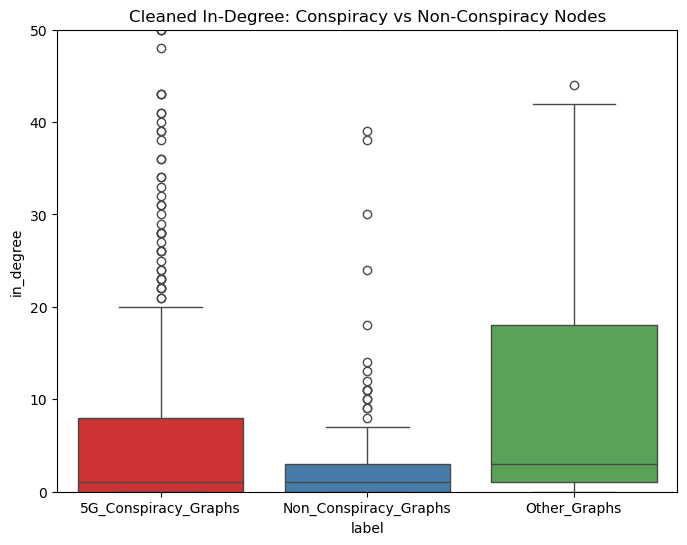

In [6]:
# CELL 6: Cleaned Degree Plot
print("--- CLEANED DEGREE DISTRIBUTION ---")

clean_sample = clean_sg.select("label", "in_degree").sample(0.2, seed=42).toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(data=clean_sample, x='label', y='in_degree', hue='label', showfliers=True, palette='Set1')
plt.title("Cleaned In-Degree: Conspiracy vs Non-Conspiracy Nodes")
plt.ylim(0, 50)
plt.show()

--- VISUALIZING ONE REAL 5G-CONSPIRACY-DOMINATED GRAPH (Colored by Label) ---
Visualizing real 5G-conspiracy graph ID: 200
Graph has 160 nodes (after removing 0 seed accounts if present) and 265 edges


/tmp/ipykernel_249/2034136569.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


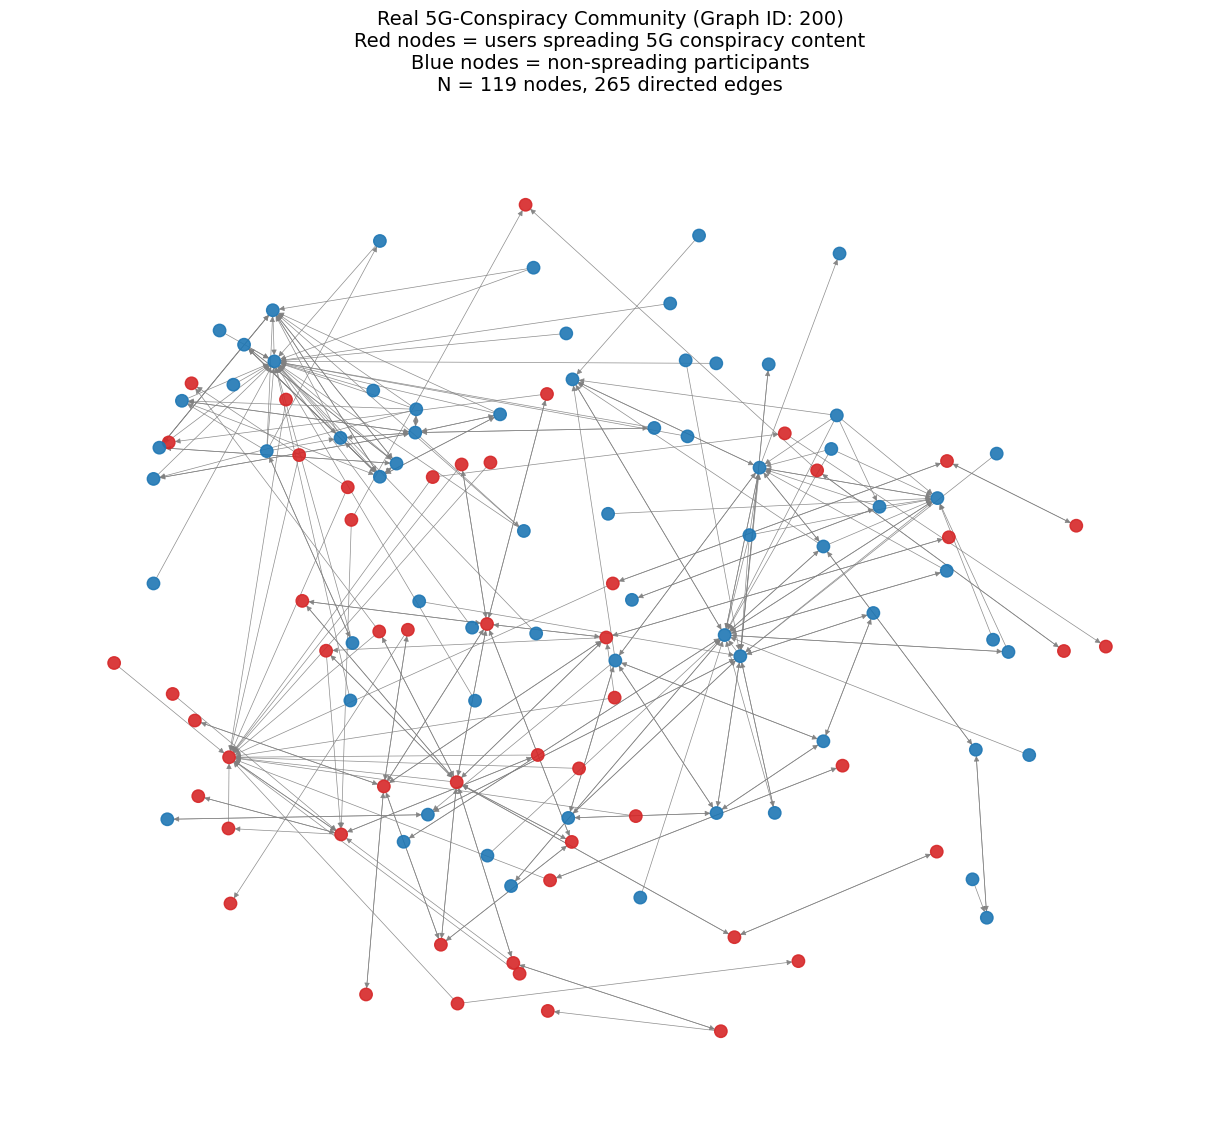

In [8]:
# CELL 7 — FINAL VISUALIZATION (100% WORKING)

print("--- VISUALIZING ONE REAL 5G-CONSPIRACY-DOMINATED GRAPH (Colored by Label) ---")

# 1. Pick one of the 35 real conspiracy graphs
sample_gid = pivot_nodes.filter(col("dominant_label") == "5G_Conspiracy") \
                        .select("graph_id") \
                        .limit(1) \
                        .collect()[0][0]

print(f"Visualizing real 5G-conspiracy graph ID: {sample_gid}")

# 2. Get edges and nodes for this graph only
g_edges = edges_df.filter(col("graph_id") == sample_gid).toPandas()
g_nodes = nodes_df.filter(col("graph_id") == sample_gid).toPandas()

# 3. Remove the artificial seed account (if it exists in this graph)
# → artificial_seeds is a DataFrame → we need the actual list of IDs
seed_ids_list = [row.id for row in artificial_seeds.select("id").collect()]

g_nodes_clean = g_nodes[~g_nodes['id'].isin(seed_ids_list)]

print(f"Graph has {g_nodes_clean.shape[0]} nodes (after removing {len(seed_ids_list)} seed accounts if present) "
      f"and {g_edges.shape[0]} edges")

# 4. Build NetworkX graph
G = nx.from_pandas_edgelist(g_edges, source="src_node_id", target="dst_node_id", create_using=nx.DiGraph())

# 5. Node colors: red = conspiracy spreader, blue = everyone else
color_map = []
for node in G.nodes():
    label = g_nodes_clean[g_nodes_clean['id'] == node]['label'].values
    if len(label) > 0 and "5G_Conspiracy_Graphs" in label[0]:
        color_map.append('#d62728')   # red
    else:
        color_map.append('#1f77b4')   # blue

# 6. Plot
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)

nx.draw(G, pos,
        node_color=color_map,
        node_size=80,
        alpha=0.9,
        edge_color='gray',
        width=0.5,
        arrows=True,
        arrowsize=8,
        with_labels=False)

plt.title(f"Real 5G-Conspiracy Community (Graph ID: {sample_gid})\n"
          f"Red nodes = users spreading 5G conspiracy content\n"
          f"Blue nodes = non-spreading participants\n"
          f"N = {G.number_of_nodes()} nodes, {G.number_of_edges()} directed edges",
          fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()